In [90]:
import os
import copy
import datetime
import pandas as pd
import numpy as np
from statistics import mean
from typing import Tuple, Union
from data_functions import Data_Functions, load_results


class Audio_Narrative(Data_Functions):
    """
    This class contains functions, data structures, and info necessary for
    processing the Audio Narrative experiment.

    Args:
        Data_Functions (class): Experiment processing functions

    Attributes:
        exp_name: Name of the experiment
        num_blocks: Number of blocks in the experiment
        num_trials: Number of trials in the experiment
        clip_duration: Number of seconds in the narrative clip
        data_filepath: Path to the experiment directory
        marker_data: Start and end marker data for the experiment
        df: Full experimental data
        df_simp: Selection of experimental data
        response: Participant response to the narrative
        block_start_time: Start timestamp of the narrative clip
    """

    def __init__(self, par_dir):
        super().__init__()
        self.exp_name = "audio_narrative"
        self.num_blocks = 1
        self.num_trials = 1
        self.clip_duration = 423  # seconds
        self.data_filepath = self.get_data_filepath(
            par_dir=par_dir, exp_name=self.exp_name
        )

        self.marker_data = self.parse_log_file(par_dir=par_dir, exp_name=self.exp_name)
        self.df = pd.read_csv(self.data_filepath)

        cols = ["pieman_clip.started", "participant_response.text"]
        self.df_simp = self.get_cols(df=self.df, cols=cols)
        self.df_simp.insert(
            1,
            "pieman_clip.ended",
            self.df_simp["pieman_clip.started"] + self.clip_duration,
        )

        self.response = self.get_response()
        self.block_start_time = self.get_clip_start_time()

    def get_response(self):
        try:
            return self.df_simp["participant_response.text"][0]
        except:
            print(
                "Audio Narrative: Need to combine 'participant response' columns into a single column."
            )

    def get_clip_start_time(self):
        return self.df_simp["pieman_clip.started"][0]


class Go_No_Go(Data_Functions):
    """
    This class contains functions, data structures, and info necessary for
    processing the Go/No-Go experiment.

    Args:
        Data_Functions (class): Experiment processing functions

    Attributes:
        exp_name: Name of the experiment
        num_blocks: Number of blocks in the experiment
        num_trials: Number of trials in the experiment
        data_filepath: Path to the experiment directory
        marker_data: Start and end marker data for the experiment
        task_order: Order of experiment tasks
        task_order_simp: Simplified order of experiment tasks
        df: Full experimental data
        df_simp: Selection of experimental data
        df_by_block: Selection of experimental data organized into task blocks
    """

    def __init__(self, par_dir):
        super().__init__()
        self.exp_name = "go_no_go"
        self.num_blocks = 4
        self.num_trials = 20
        # NOTE: stimulus duration depends on participant response
        # NOTE: inter-stimulus duration is variable
        self.data_filepath = self.get_data_filepath(
            par_dir=par_dir, exp_name=self.exp_name
        )
        self.marker_data = self.parse_log_file(par_dir=par_dir, exp_name=self.exp_name)

        self.task_order = self.parse_task_order_file(
            par_dir=par_dir, exp_name=self.exp_name
        )
        self.task_order_simp = self._simp_task_order(task_order=self.task_order)

        self.df = pd.read_csv(self.data_filepath)
        cols = [
            "match",
            "GNG_stim",
            "inter_stim_plus.started",
            "go_image.started",
            "go_image.stopped",
            "go_resp.corr",
            "go_resp.rt",
        ]
        for idx, row in self.df.iterrows():
            if (
                row["go_image.stopped"] == float("NaN")
                or row["go_image.stopped"] == "None"
            ):
                self.df.at[idx, "go_image.stopped"] = (
                    row["go_image.started"] + row["go_resp.rt"]
                )

        self.df_simp = self.get_cols(df=self.df, cols=cols)
        self.df_simp = self.df_simp.copy()
        self.df_simp["GNG_stim"] = self.df_simp["GNG_stim"].apply(self._strip_stim)
        self.df_simp.insert(
            3,
            "inter_stim_plus.ended",
            self.df_simp["inter_stim_plus.started"] + self.df["inter_stim_interval"],
        )
        # self.df_simp.rename(
        #     columns={
        #         "go_image.stopped": "go_image.ended",
        #     },
        #     inplace=True,
        # )
        # self.df_simp.insert(
        #     5,
        #     "go_image.ended",
        #     self.df_simp["go_image.started"] + self.df_simp["go_resp.rt"],
        # )

        self.df_by_block, self.df_no_nan = self.parse_df(
            df=self.df_simp, num_blocks=self.num_blocks, num_trials=self.num_trials
        )

        self._correct_responses(df_by_block=self.df_by_block)
        self._response_times(df_by_block=self.df_by_block)

    def _simp_task_order(self, task_order):
        task_order = task_order["task_order"].to_list()
        task_order_simp = [task.split("_")[0] for task in task_order]

        return task_order_simp

    def _strip_stim(self, row):
        try:
            return row.split("\\")[0].split("_stimuli")[0]
        except:
            return row

    def _correct_responses(self, df_by_block):
        self.num_corr_go_list = []
        self.num_corr_gng_list = []

        for i, block in enumerate(df_by_block.values()):
            if (i + 1) % 2 != 0:  # Go blocks
                num_corr_go = int(sum(block["go_resp.corr"]))
                self.num_corr_go_list.append(num_corr_go)
            else:  # Go/No-Go blocks
                num_corr_gng = int(sum(block["go_resp.corr"]))
                self.num_corr_gng_list.append(num_corr_gng)

        self.total_corr_go = sum(self.num_corr_go_list)
        self.total_corr_gng = sum(self.num_corr_gng_list)
        self.total_corr = self.total_corr_go + self.total_corr_gng

    def _response_times(self, df_by_block):
        self.resp_time_go_list = []
        self.resp_time_gng_list = []

        for i, block in enumerate(df_by_block.values()):
            if (i + 1) % 2 != 0:  # Go blocks
                try:  # handle Nan
                    resp_time_go = np.nanmean(block["go_resp.rt"])
                    self.resp_time_go_list.append(resp_time_go)
                except:
                    pass
            else:  # Go/No-Go blocks
                try:  # handle Nan
                    resp_time_gng = np.nanmean(block["go_resp.rt"])
                    self.resp_time_gng_list.append(resp_time_gng)
                except:
                    pass

        self.avg_resp_time_go = mean(self.resp_time_go_list)
        self.avg_resp_time_gng = mean(self.resp_time_gng_list)
        self.avg_resp_time = [self.avg_resp_time_go, self.avg_resp_time_gng]


class King_Devick(Data_Functions):
    """
    This class contains functions, data structures, and info necessary for
    processing the King Devick experiment.

    Args:
        Data_Functions (class): Experiment processing functions

    Attributes:
        exp_name: Name of the experiment
        num_blocks: Number of blocks in the experiment
        num_trials: Number of trials in the experiment
        data_filepath: Path to the experiment directory
        marker_data: Start and end marker data for the experiment
        task_order: Order of experiment tasks
        task_order_new: Simplified order of experiment tasks
        df: Full experimental data
        df_simp: Selection of experimental data
    """

    def __init__(self, par_dir):
        super().__init__()
        self.exp_name = "king_devick"
        self.num_blocks = 1
        self.num_trials = 3
        self.num_trials_new = 4  # added a card for participants 15+
        # NOTE: card duration depends on participant response
        self.data_filepath = self.get_data_filepath(
            par_dir=par_dir, exp_name=self.exp_name
        )
        self.marker_data = self.parse_log_file(par_dir=par_dir, exp_name=self.exp_name)

        self.task_order = ["card_1", "card_2", "card_3"]
        self.task_order_new = [
            "card_1",
            "card_2",
            "card_3",
            "card_4",
        ]  # added a card for participants 15+

        self.df = pd.read_csv(self.data_filepath)
        num_incorrect_col = pd.Series(self._parse_data_file(par_dir=par_dir))
        self.df.insert(len(self.df.columns), "num_incorrect", num_incorrect_col)
        cols = ["card_image.started", "card_resp.rt", "num_incorrect"]
        self.df_simp = self.get_cols(self.df, cols)
        self.df_simp.insert(
            1,
            "card_image.ended",
            self.df_simp["card_image.started"] + self.df_simp["card_resp.rt"],
        )

    def _parse_data_file(self, par_dir):
        data_dir = os.path.join(par_dir, self.exp_name, "data")
        for filename in os.listdir(data_dir):
            if "data.txt" in filename:
                data_filename = filename
        data_filepath = os.path.join(data_dir, data_filename)

        with open(data_filepath) as f:
            lines = f.readlines()

        par_resp = []
        for line in lines:
            if "number incorrect" in line:
                par_resp.append(line.split(" ")[-1].strip("\n"))

        return par_resp


class N_Back(Data_Functions):
    """
    This class contains functions, data structures, and info necessary for
    processing the N-Back experiment.

    Args:
        Data_Functions (class): Experiment processing functions

    Attributes:
        exp_name: Name of the experiment
        num_blocks: Number of blocks in the experiment
        num_trials: Number of trials in the experiment
        stim_duration: Duration of stimulus
        inter_stim_duration: Duration between stimuli
        data_filepath: Path to the experiment directory
        marker_data: Start and end marker data for the experiment
        task_order: Order of experiment tasks
        task_order_simp: Simplified order of experiment tasks
        df: Full experimental data
        df_simp: Selection of experimental data
        df_by_block: Selection of experimental data organized into task blocks
    """

    def __init__(self, par_dir):
        super().__init__()
        self.exp_name = "n_back"
        self.num_blocks = 9
        self.num_trials = 20
        self.stim_duration = 0.5  # seconds
        self.inter_stim_duration = 3.0  # seconds
        self.data_filepath = self.get_data_filepath(
            par_dir=par_dir, exp_name=self.exp_name
        )
        self.marker_data = self.parse_log_file(par_dir=par_dir, exp_name=self.exp_name)

        self.task_order = self.parse_task_order_file(
            par_dir=par_dir, exp_name=self.exp_name
        )
        self.task_order_simp, self.task_order_simp2 = self._simp_task_order(
            task_order=self.task_order
        )

        self.df = pd.read_csv(self.data_filepath)
        cols = ["match", "stim_text.started", "stim_resp.corr", "stim_resp.rt"]
        self.df_simp = self.get_cols(df=self.df, cols=cols)
        self.df_simp.insert(
            2, "stim_text.ended", self.df_simp["stim_text.started"] + 0.5
        )  # stimulus duration is 0.5 seconds
        self.df_simp.insert(
            3, "inter_stim.started", self.df_simp["stim_text.started"] + 0.5
        )  # inter-stimulus interval starts 0.5 seconds after stimulus
        self.df_simp.insert(
            4, "inter_stim.ended", self.df_simp["inter_stim.started"] + 3
        )  # inter-stimulus duration is 3 seconds
        self.df_by_block, self.df_no_nan = self.parse_df(
            df=self.df_simp, num_blocks=self.num_blocks, num_trials=self.num_trials
        )

        self._correct_responses(df_by_block=self.df_by_block)
        self._response_times(df_by_block=self.df_by_block)

    def _correct_responses(self, df_by_block):
        self.num_corr_ZB_list = []
        self.num_corr_OB_list = []
        self.num_corr_TB_list = []

        for task_type, block in zip(self.task_order_simp, df_by_block.values()):
            if "0_back" in task_type:
                num_corr_ZB = int(sum(block["stim_resp.corr"]))
                self.num_corr_ZB_list.append(num_corr_ZB)
            elif "1_back" in task_type:
                num_corr_OB = int(sum(block["stim_resp.corr"]))
                self.num_corr_OB_list.append(num_corr_OB)
            elif "2_back" in task_type:
                num_corr_TB = int(sum(block["stim_resp.corr"]))
                self.num_corr_TB_list.append(num_corr_TB)

        self.total_corr_ZB = sum(self.num_corr_ZB_list)
        self.total_corr_OB = sum(self.num_corr_OB_list)
        self.total_corr_TB = sum(self.num_corr_TB_list)
        self.total_corr = self.total_corr_ZB + self.total_corr_OB + self.total_corr_TB

    def _response_times(self, df_by_block):
        self.resp_time_ZB_list = []
        self.resp_time_OB_list = []
        self.resp_time_TB_list = []

        for task_type, block in zip(self.task_order_simp, df_by_block.values()):
            if "0_back" in task_type:
                resp_time_ZB = np.nanmean(block["stim_resp.rt"])
                self.resp_time_ZB_list.append(resp_time_ZB)
            elif "1_back" in task_type:
                resp_time_OB = np.nanmean(block["stim_resp.rt"])
                self.resp_time_OB_list.append(resp_time_OB)
            elif "2_back" in task_type:
                resp_time_TB = np.nanmean(block["stim_resp.rt"])
                self.resp_time_TB_list.append(resp_time_TB)

        self.avg_resp_time_ZB = mean(self.resp_time_ZB_list)
        self.avg_resp_time_OB = mean(self.resp_time_OB_list)
        self.avg_resp_time_TB = mean(self.resp_time_TB_list)
        self.avg_resp_time = [
            self.avg_resp_time_ZB,
            self.avg_resp_time_OB,
            self.avg_resp_time_TB,
        ]

    def _simp_task_order(self, task_order):
        task_order = task_order["task_order"].to_list()
        task_order_simp = []
        task_order_simp2 = []
        for task in task_order:
            if "ZB" in task:
                temp = task.split("-")
                task_simp = f"0_back-{temp[1]}"
                task_simp2 = "0_back"
            elif "OB" in task:
                task_simp = "1_back"
                task_simp2 = "1_back"
            elif "TB" in task:
                task_simp = "2_back"
                task_simp2 = "2_back"
            task_order_simp.append(task_simp)
            task_order_simp2.append(task_simp2)

        return task_order_simp, task_order_simp2


class Resting_State(Data_Functions):
    """
    This class contains functions, data structures, and info necessary for
    processing the Resting State experiment.

    Args:
        Data_Functions (class): Experiment processing functions

    Attributes:
        exp_name: Name of the experiment
        num_blocks: Number of blocks in the experiment
        num_trials: Number of trials in the experiment
        session_duration: Duration of each session (eyes open and eyes closed)
        inter_stim_duration: Duration between stimuli
        data_filepath: Path to the experiment directory
        marker_data: Start and end marker data for the experiment
        task_order: Order of experiment tasks
        task_order_simp: Simplified order of experiment tasks
        df: Full experimental data
        df_simp: Selection of experimental data
    """

    def __init__(self, par_dir):
        super().__init__()
        self.exp_name = "resting_state"
        self.num_blocks = 2
        self.num_trials = 1
        self.session_duration = 210  # seconds for each task (eyes open and eyes closed)
        self.data_filepath = self.get_data_filepath(
            par_dir=par_dir, exp_name=self.exp_name
        )
        self.marker_data = self.parse_log_file(par_dir=par_dir, exp_name=self.exp_name)

        self.task_order = self.parse_task_order_file(
            par_dir=par_dir, exp_name=self.exp_name
        )
        self.task_order_simp = self._simp_task_order(task_order=self.task_order)

        self.df = pd.read_csv(self.data_filepath)
        cols = ["trial_cross.started", "halfway_tone.started", "done_sound.started"]
        self.df_simp = self.get_cols(df=self.df, cols=cols)

    def _simp_task_order(self, task_order):
        task_order = task_order["task_order"].to_list()
        task_order_simp = [task.replace(" ", "_") for task in task_order]

        return task_order_simp


class Tower_of_London(Data_Functions):
    """
    This class contains functions, data structures, and info necessary for
    processing the Tower of London experiment.

    Args:
        Data_Functions (class): Experiment processing functions

    Attributes:
        exp_name: Name of the experiment
        num_blocks: Number of blocks in the experiment
        num_trials: Number of trials in the experiment
        stim_duration: Duration of stimulus
        response_duration: Duration the participant has to respond
        data_filepath: Path to the experiment directory
        marker_data: Start and end marker data for the experiment
        task_order: Order of experiment tasks
        task_order_simp: Simplified order of experiment tasks
        df: Full experimental data
        df_simp: Selection of experimental data
        df_by_block: Selection of experimental data organized into task blocks
    """

    def __init__(self, par_dir):
        super().__init__()
        self.exp_name = "tower_of_london"
        self.num_blocks = 6
        self.num_trials = 6
        self.stim_duration = 7  # seconds
        self.response_duration = 3  # seconds
        self.data_filepath = self.get_data_filepath(
            par_dir=par_dir, exp_name=self.exp_name
        )
        self.marker_data = self.parse_log_file(par_dir=par_dir, exp_name=self.exp_name)

        self.task_order = self.parse_task_order_file(
            par_dir=par_dir, exp_name=self.exp_name
        )
        self.task_order_simp = self._simp_task_order(task_order=self.task_order)

        self.df = pd.read_csv(self.data_filepath)
        cols = [
            "match",
            "image_stim",
            "stim_image.started",
            "stim_text.started",
            "stim_resp.corr",
            "stim_resp.rt",
        ]
        self.df_simp = self.get_cols(df=self.df, cols=cols)
        self.df_simp = self.df_simp.copy()
        self.df_simp["image_stim"] = self.df_simp["image_stim"].apply(self._strip_stim)
        self.df_simp.insert(
            3,
            "stim_image.ended",
            self.df_simp["stim_image.started"] + self.stim_duration,
        )
        self.df_simp.insert(
            5,
            "stim_text.ended",
            self.df_simp["stim_text.started"] + self.response_duration,
        )
        self.df_by_block, self.df_no_nan = self.parse_df(
            df=self.df_simp, num_blocks=self.num_blocks, num_trials=self.num_trials
        )

        self._correct_responses(df_by_block=self.df_by_block)
        self._response_times(df_by_block=self.df_by_block)

    def _strip_stim(self, row):
        try:
            temp_list = row.split("\\")
            if len(temp_list) == 3:
                return temp_list[1].split("stim_")[1]
            else:
                return temp_list[0].split("_stimuli")[0]
        except:
            return row

    def _correct_responses(self, df_by_block):
        self.num_corr_MM_list = []
        self.num_corr_ZM_list = []

        for task_type, block in zip(self.task_order_simp, df_by_block.values()):
            if task_type == "MM":
                num_corr_MM = int(sum(block["stim_resp.corr"]))
                self.num_corr_MM_list.append(num_corr_MM)
            elif task_type == "ZM":
                num_corr_ZM = int(sum(block["stim_resp.corr"]))
                self.num_corr_ZM_list.append(num_corr_ZM)

        self.total_corr_MM = sum(self.num_corr_MM_list)
        self.total_corr_ZM = sum(self.num_corr_ZM_list)
        self.total_corr = self.total_corr_MM + self.total_corr_ZM

    def _response_times(self, df_by_block):
        self.resp_time_MM_list = []
        self.resp_time_ZM_list = []

        for task_type, block in zip(self.task_order_simp, df_by_block.values()):
            if task_type == "MM":
                resp_time_MM = np.nanmean(block["stim_resp.rt"])
                self.resp_time_MM_list.append(resp_time_MM)
            elif task_type == "ZM":
                resp_time_ZM = np.nanmean(block["stim_resp.rt"])
                self.resp_time_ZM_list.append(resp_time_ZM)

        self.avg_resp_time_MM = mean(self.resp_time_MM_list)
        self.avg_resp_time_ZM = mean(self.resp_time_ZM_list)
        self.avg_resp_time = [self.avg_resp_time_MM, self.avg_resp_time_ZM]

    def _simp_task_order(self, task_order):
        task_order = task_order["task_order"].to_list()
        task_order_simp = [task.split("_")[0] for task in task_order]

        return task_order_simp


class Video_Narrative_CMIYC(Data_Functions):
    """
    This class contains functions, data structures, and info necessary for
    processing the Video Narrative CMIYC experiment.

    Args:
        Data_Functions (class): Experiment processing functions

    Attributes:
        exp_name: Name of the experiment
        num_blocks: Number of blocks in the experiment
        num_trials: Number of trials in the experiment
        clip_duration: Number of seconds in the narrative clip
        data_filepath: Path to the experiment directory
        marker_data: Start and end marker data for the experiment
        df: Full experimental data
        df_simp: Selection of experimental data
        response: Participant response to the narrative
        block_start_time: Start timestamp of the narrative clip
    """

    def __init__(self, par_dir):
        super().__init__()
        self.exp_name = "video_narrative_cmiyc"
        self.num_blocks = 1
        self.num_trials = 1
        self.clip_duration = 300  # seconds
        self.data_filepath = self.get_data_filepath(
            par_dir=par_dir, exp_name=self.exp_name
        )
        self.marker_data = self.parse_log_file(par_dir=par_dir, exp_name=self.exp_name)

        self.df = pd.read_csv(self.data_filepath)
        cols = ["video_start.started", "catchme_participant_response.text"]
        self.df_simp = self.get_cols(df=self.df, cols=cols)
        self.df_simp.insert(
            1,
            "video_start.ended",
            self.df_simp["video_start.started"] + self.clip_duration,
        )

        self.response = self.get_response()
        self.block_start_time = self.get_clip_start_time()

    def get_response(self):
        try:
            return self.df_simp["catchme_participant_response.text"][0]
        except:
            print(
                "Video Narrative CMIYC: Need to combine 'participant response' columns into a single column."
            )

    def get_clip_start_time(self):
        return self.df_simp["video_start.started"][0]


class Video_Narrative_Sherlock(Data_Functions):
    """
    This class contains functions, data structures, and info necessary for
    processing the Video Narrative Sherlock experiment.

    Args:
        Data_Functions (class): Experiment processing functions

    Attributes:
        exp_name: Name of the experiment
        num_blocks: Number of blocks in the experiment
        num_trials: Number of trials in the experiment
        clip_duration: Number of seconds in the narrative clip
        data_filepath: Path to the experiment directory
        marker_data: Start and end marker data for the experiment
        df: Full experimental data
        df_simp: Selection of experimental data
        response: Participant response to the narrative
        block_start_time: Start timestamp of the narrative clip
    """

    def __init__(self, par_dir):
        super().__init__()
        self.exp_name = "video_narrative_sherlock"
        self.num_blocks = 1
        self.num_trials = 1
        self.clip_duration = 300  # seconds
        self.data_filepath = self.get_data_filepath(
            par_dir=par_dir, exp_name=self.exp_name
        )
        self.marker_data = self.parse_log_file(par_dir=par_dir, exp_name=self.exp_name)

        self.df = pd.read_csv(self.data_filepath)
        cols = ["video_start.started", "sherlock_participant_response.text"]
        self.df_simp = self.get_cols(df=self.df, cols=cols)
        self.df_simp.insert(
            1,
            "video_start.ended",
            self.df_simp["video_start.started"] + self.clip_duration,
        )

        self.response = self.get_response()
        self.block_start_time = self.get_clip_start_time()

    def get_response(self):
        try:
            return self.df_simp["sherlock_participant_response.text"][0]
        except:
            print(
                "ERROR: Sherlock - Need to combine 'participant response' columns into a single column."
            )

    def get_clip_start_time(self):
        return self.df_simp["video_start.started"][0]


class vSAT(Data_Functions):
    """
    This class contains functions, data structures, and info necessary for
    processing the vSAT experiment.

    Args:
        Data_Functions (class): Experiment processing functions

    Attributes:
        exp_name: Name of the experiment
        num_blocks: Number of blocks in the experiment
        num_trials: Number of trials in the experiment
        data_filepath: Path to the experiment directory
        marker_data: Start and end marker data for the experiment
        task_order: Order of experiment tasks
        task_order_simp: Simplified order of experiment tasks
        df: Full experimental data
        df_simp: Selection of experimental data
        df_by_block: Selection of experimental data organized into task blocks
    """

    def __init__(self, par_dir):
        super().__init__()
        self.exp_name = "vSAT"
        self.num_blocks = 4
        self.num_trials = 30
        # NOTE: stimulus duration is variable
        # NOTE: stimulus location is variable
        # NOTE: inter-stimulus duration is variable
        self.data_filepath = self.get_data_filepath(
            par_dir=par_dir, exp_name=self.exp_name
        )
        self.marker_data = self.parse_log_file(par_dir=par_dir, exp_name=self.exp_name)

        self.task_order = self.parse_task_order_file(
            par_dir=par_dir, exp_name=self.exp_name
        )
        self.task_order_simp = self._simp_task_order(task_order=self.task_order)

        self.df = pd.read_csv(self.data_filepath)
        cols = [
            "match",
            "stim_time",
            "inter_stim_time",
            "x_pos",
            "y_pos",
            "inter_stim_text.started",
            "vSAT_square.started",
            "stim_resp.corr",
            "stim_resp.rt",
            "feedback_sound.started",
        ]
        self.df_simp = self.get_cols(df=self.df, cols=cols)
        self._add_pos_col()
        self.df_simp.insert(
            5,
            "inter_stim_text.ended",
            self.df_simp["inter_stim_text.started"] + self.df_simp["inter_stim_time"],
        )
        self.df_simp.insert(
            7,
            "vSAT_square.ended",
            self.df_simp["vSAT_square.started"] + self.df_simp["stim_time"],
        )
        self.df_simp.insert(
            11, "feedback_sound.ended", self.df_simp["feedback_sound.started"] + 0.5
        )  # 0.5 second feedback sound
        self.df_by_block, self.df_no_nan = self.parse_df(
            df=self.df_simp, num_blocks=self.num_blocks, num_trials=self.num_trials
        )

        self._correct_responses(df_by_block=self.df_by_block)
        self._response_times(df_by_block=self.df_by_block)

    def _correct_responses(self, df_by_block):
        self.num_corr_SAT_list = []
        self.num_corr_vSAT_list = []

        for task_type, block in zip(self.task_order_simp, df_by_block.values()):
            if task_type == "SAT":
                num_corr_SAT = int(sum(block["stim_resp.corr"]))
                self.num_corr_SAT_list.append(num_corr_SAT)
            elif task_type == "vSAT":
                num_corr_vSAT = int(sum(block["stim_resp.corr"]))
                self.num_corr_vSAT_list.append(num_corr_vSAT)

        self.total_corr_SAT = sum(self.num_corr_SAT_list)
        self.total_corr_vSAT = sum(self.num_corr_vSAT_list)
        self.total_corr = self.total_corr_SAT + self.total_corr_vSAT

    def _response_times(self, df_by_block):
        self.resp_time_SAT_list = []
        self.resp_time_vSAT_list = []

        for task_type, block in zip(self.task_order_simp, df_by_block.values()):
            if task_type == "SAT":
                resp_time_SAT = np.nanmean(block["stim_resp.rt"])
                self.resp_time_SAT_list.append(resp_time_SAT)
            elif task_type == "vSAT":
                resp_time_vSAT = np.nanmean(block["stim_resp.rt"])
                self.resp_time_vSAT_list.append(resp_time_vSAT)

        self.avg_resp_time_SAT = mean(self.resp_time_SAT_list)
        self.avg_resp_time_vSAT = mean(self.resp_time_vSAT_list)
        self.avg_resp_time = [self.avg_resp_time_SAT, self.avg_resp_time_vSAT]

    def _simp_task_order(self, task_order):
        task_order = task_order["task_order"].to_list()
        task_order_simp = [task.split("_")[0] for task in task_order]

        return task_order_simp

    def _add_pos_col(self):
        x_pos_col = self.df_simp["x_pos"]
        y_pos_col = self.df_simp["y_pos"]

        pos_list = []
        for x_pos, y_pos in zip(x_pos_col, y_pos_col):
            if x_pos == 0 and y_pos == 0:
                pos = "center"
                pos_list.append(pos)
            elif x_pos == 0.25 and y_pos == 0.25:
                pos = "top-right"
                pos_list.append(pos)
            elif x_pos == 0.25 and y_pos == -0.25:
                pos = "bottom-right"
                pos_list.append(pos)
            elif x_pos == -0.25 and y_pos == 0.25:
                pos = "top-left"
                pos_list.append(pos)
            elif x_pos == -0.25 and y_pos == -0.25:
                pos = "bottom-left"
                pos_list.append(pos)
            else:
                pos = "Nan"
                pos_list.append(pos)

        self.df_simp.insert(loc=4, column="position", value=pos_list)
        self.df_simp = self.df_simp.drop(columns=["x_pos", "y_pos"])


class Participant_Behav(Data_Functions):
    """
    This class contains functions, data structures, and info necessary for
    processing participants and behavioral data from the experiments.

    Args:
        Data_Functions (class): Experiment processing functions.

    Attributes:
        par_num: Participant number
        par_id: Participant ID
        par_dir: Path to specific participant directory
        exp_order: Experiment order
        all_marker_timestamps: Dictionary with start and end timestamps for each experiment
        marker_ts_df: DataFrame with start and end timestamps for each experiment
        audio_narrative: Audio Narrative experiment instance
        go_no_go: Go/No-Go experiment instance
        king_devick: King Devick experiment instance
        n_back: N-Back experiment instance
        tower_of_london: Tower of London experiment instance
        video_narrative_cmiyc: Video Narrative CMIYC experiment instance
        video_narrative_sherlock: Video Narrative Sherlock experiment instance
        vSAT: vSAT experiment instance
    """

    def __init__(self, par_num, adj_ts_markers=True):
        super().__init__()
        self.par_num, self.par_ID = self.process_par(par_num)
        self.raw_data_dir = r"C:\Kernel\raw_data"  # TODO: make this path relative
        self.processed_data_dir = os.path.join(
            os.getcwd(), "processed_data", "behavioral"
        )
        self.par_dir = os.path.join(self.raw_data_dir, self.par_ID)
        self.forms_filepath = os.path.join(
            os.getcwd(), "processed_data", "participant_forms.xlsx"
        )
        self.exp_order = self.get_exp_order()
        self.session_dict = self.create_session_dict()
        self.form_info = self.load_form_info()

        self.all_marker_timestamps = self.get_all_marker_timestamps(
            par_dir=self.par_dir, exp_order=self.exp_order
        )
        if adj_ts_markers:
            self.all_marker_timestamps_adj = self.adjust_all_marker_timestamps(
                copy.deepcopy(self.all_marker_timestamps),
                self.processed_data_dir,
                self.par_num,
            )
        self._create_marker_ts_csv()
        marker_csv_filepath = r"C:\Users\zackg\OneDrive\Ayaz Lab\KernelFlow_Experiment\main\marker_dict.csv"
        self.marker_dict = self.load_marker_dict(
            marker_csv_filepath
        )  # TODO: make this path relative
        self.marker_ts_df = self._create_marker_ts_df()

        self.audio_narrative = Audio_Narrative(par_dir=self.par_dir)
        self.audio_narrative.start_ts = self.get_start_ts(
            "audio_narrative", adj_ts_markers
        )
        self.audio_narrative.end_ts = self.get_end_ts("audio_narrative", adj_ts_markers)
        self.audio_narrative.df_adj_ts = self.adjust_df_ts(
            self.audio_narrative.df_simp,
            self.audio_narrative.start_ts,
            ["pieman_clip.started", "pieman_clip.ended"],
        )

        self.go_no_go = Go_No_Go(par_dir=self.par_dir)
        self.go_no_go.start_ts = self.get_start_ts("go_no_go", adj_ts_markers)
        self.go_no_go.end_ts = self.get_end_ts("go_no_go", adj_ts_markers)
        self.go_no_go.df_adj_ts = self.adjust_df_ts(
            self.go_no_go.df_no_nan,
            self.go_no_go.start_ts,
            [
                "inter_stim_plus.started",
                "inter_stim_plus.ended",
                "go_image.started",
                "go_image.stopped",
            ],
        )
        self.go_no_go.df_by_block_adj_ts = self.adjust_df_ts(
            self.go_no_go.df_by_block,
            self.go_no_go.start_ts,
            [
                "inter_stim_plus.started",
                "inter_stim_plus.ended",
                "go_image.started",
                "go_image.stopped",
            ],
            by_block=True,
        )

        self.king_devick = King_Devick(par_dir=self.par_dir)
        self.king_devick.start_ts = self.get_start_ts("king_devick", adj_ts_markers)
        self.king_devick.end_ts = self.get_end_ts("king_devick", adj_ts_markers)
        self.king_devick.df_adj_ts = self.adjust_df_ts(
            self.king_devick.df_simp,
            self.king_devick.start_ts,
            ["card_image.started", "card_image.ended"],
        )

        self.n_back = N_Back(par_dir=self.par_dir)
        self.n_back.start_ts = self.get_start_ts("n_back", adj_ts_markers)
        self.n_back.end_ts = self.get_end_ts("n_back", adj_ts_markers)
        self.n_back.df_adj_ts = self.adjust_df_ts(
            self.n_back.df_no_nan,
            self.n_back.start_ts,
            [
                "stim_text.started",
                "stim_text.ended",
                "inter_stim.started",
                "inter_stim.ended",
            ],
        )
        self.n_back.df_by_block_adj_ts = self.adjust_df_ts(
            self.n_back.df_by_block,
            self.n_back.start_ts,
            [
                "stim_text.started",
                "stim_text.ended",
                "inter_stim.started",
                "inter_stim.ended",
            ],
            by_block=True,
        )

        self.resting_state = Resting_State(par_dir=self.par_dir)
        self.resting_state.start_ts = self.get_start_ts("resting_state", adj_ts_markers)
        self.resting_state.end_ts = self.get_end_ts("resting_state", adj_ts_markers)
        self.resting_state.df_adj_ts = self.adjust_df_ts(
            self.resting_state.df_simp,
            self.resting_state.start_ts,
            ["trial_cross.started", "halfway_tone.started", "done_sound.started"],
        )

        self.tower_of_london = Tower_of_London(par_dir=self.par_dir)
        self.tower_of_london.start_ts = self.get_start_ts(
            "tower_of_london", adj_ts_markers
        )
        self.tower_of_london.end_ts = self.get_end_ts("tower_of_london", adj_ts_markers)
        self.tower_of_london.df_adj_ts = self.adjust_df_ts(
            self.tower_of_london.df_no_nan,
            self.tower_of_london.start_ts,
            [
                "stim_image.started",
                "stim_image.ended",
                "stim_text.started",
                "stim_text.ended",
            ],
        )
        self.tower_of_london.df_by_block_adj_ts = self.adjust_df_ts(
            self.tower_of_london.df_by_block,
            self.tower_of_london.start_ts,
            [
                "stim_image.started",
                "stim_image.ended",
                "stim_text.started",
                "stim_text.ended",
            ],
            by_block=True,
        )

        self.video_narrative_cmiyc = Video_Narrative_CMIYC(par_dir=self.par_dir)
        self.video_narrative_cmiyc.start_ts = self.get_start_ts(
            "video_narrative_cmiyc", adj_ts_markers
        )
        self.video_narrative_cmiyc.end_ts = self.get_end_ts(
            "video_narrative_cmiyc", adj_ts_markers
        )
        self.video_narrative_cmiyc.df_adj_ts = self.adjust_df_ts(
            self.video_narrative_cmiyc.df_simp,
            self.video_narrative_cmiyc.start_ts,
            ["video_start.started", "video_start.ended"],
        )

        self.video_narrative_sherlock = Video_Narrative_Sherlock(par_dir=self.par_dir)
        self.video_narrative_sherlock.start_ts = self.get_start_ts(
            "video_narrative_sherlock", adj_ts_markers
        )
        self.video_narrative_sherlock.end_ts = self.get_end_ts(
            "video_narrative_sherlock", adj_ts_markers
        )
        self.video_narrative_sherlock.df_adj_ts = self.adjust_df_ts(
            self.video_narrative_sherlock.df_simp,
            self.video_narrative_sherlock.start_ts,
            ["video_start.started", "video_start.ended"],
        )

        self.vSAT = vSAT(par_dir=self.par_dir)
        self.vSAT.start_ts = self.get_start_ts("vSAT", adj_ts_markers)
        self.vSAT.end_ts = self.get_end_ts("vSAT", adj_ts_markers)
        self.vSAT.df_adj_ts = self.adjust_df_ts(
            self.vSAT.df_no_nan,
            self.vSAT.start_ts,
            [
                "inter_stim_text.started",
                "inter_stim_text.ended",
                "vSAT_square.started",
                "vSAT_square.ended",
                "feedback_sound.started",
                "feedback_sound.ended",
            ],
        )
        self.vSAT.df_by_block_adj_ts = self.adjust_df_ts(
            self.vSAT.df_by_block,
            self.vSAT.start_ts,
            [
                "inter_stim_text.started",
                "inter_stim_text.ended",
                "vSAT_square.started",
                "vSAT_square.ended",
                "feedback_sound.started",
                "feedback_sound.ended",
            ],
            by_block=True,
        )

        self.by_block_ts_dict = self._create_by_block_ts_dict()

        self.exp_color_dict = {
            "audio_narrative": "yellow",
            "go_no_go": "green",
            "king_devick": "blue",
            "n_back": "purple",
            "resting_state": "pink",
            "tower_of_london": "orange",
            "video_narrative_cmiyc": "red",
            "video_narrative_sherlock": "olive",
            "vSAT": "cyan",
        }

    def get_exp_order(self) -> list:
        """
        Get the experiment order from a text file.

        Returns:
            list: Experiment order
        """

        exp_order_filename = f"{self.par_ID}_experiment_order.txt"
        exp_order_filepath = os.path.join(self.par_dir, exp_order_filename)

        with open(exp_order_filepath) as f:
            lines = f.readlines()

        exp_order = []
        for line in lines:
            if "Block" in line or "-" in line or line == "\n":
                pass
            else:
                exp_order.append(line.strip("\n"))

        return exp_order

    def create_session_dict(self) -> dict:
        """
        Create a dictionary containing the experiment names for each session.

        Returns:
            dict: Experiment names for each session.
                keys:
                    "session_1001", "session_1002", "session_1003"
                values:
                    list of experiment names
        """
        session_dict = {}
        session_exp_list = []
        session_num = 1
        for i, exp_name in enumerate(self.exp_order):
            session_exp_list.append(exp_name)
            if (i + 1) % 3 == 0:
                session_name = f"session_100{session_num}"
                session_dict[session_name] = session_exp_list
                session_num += 1
                session_exp_list = []
        return session_dict

    def load_form_info(self) -> pd.DataFrame:
        """
        Load the information from a participant's forms info a DataFrame.

        Returns:
            pd.DataFrame: DataFrame of participant form info.
        """
        forms_df = pd.read_excel(self.forms_filepath)
        form_info = forms_df[forms_df["participant"] == self.par_num]
        return form_info.reset_index()

    def _create_marker_ts_csv(self) -> None:
        """
        Create a CSV file containing the start and end timestamps for each experiment.
        """
        filepath = os.path.join(
            self.par_dir,
            f"{self.par_ID}_marker_timestamps.csv",
        )
        if os.path.exists(filepath):
            pass
        else:
            marker_list = []
            for exp_name, ts_list in self.all_marker_timestamps.items():
                temp_list = []
                temp_list.append(exp_name)
                temp_list.extend(ts_list)
                marker_list.append(temp_list)
            marker_ts_df = pd.DataFrame(
                marker_list, columns=["exp_name", "start_timestamp", "end_timestamp"]
            )
            marker_ts_df.to_csv(filepath, index=False)

    def _create_marker_ts_df(self) -> pd.DataFrame:
        """
        Create a DataFrame from a CSV file containing the start and end timestamps for each experiment.

        Returns:
            pd.DataFrame: Start and end timestamps for each experiment
        """
        marker_ts_filepath = os.path.join(
            self.par_dir, f"{self.par_ID}_marker_timestamps.csv"
        )

        return pd.read_csv(marker_ts_filepath)

    def get_start_ts(self, exp_name: str, adj_ts_markers: bool = True) -> float:
        """
        Get the start timestamp of an experiment.

        Args:
            exp_name (str): Name of the experiment.
            adj_ts_markers (bool): Use adjusted end timestamp marker. Defaults to True.

        Returns:
            float: Start timestamp of the experiment.
        """
        if adj_ts_markers:
            return float(int(self.all_marker_timestamps_adj[exp_name][0]) / 1e9)
        else:
            return float(int(self.all_marker_timestamps[exp_name][0]) / 1e9)

    def get_end_ts(self, exp_name: str, adj_ts_markers: bool = True) -> float:
        """
        Get the end timestamp of an experiment.

        Args:
            exp_name (str): Name of the experiment.
            adj_ts_markers (bool): Use adjusted end timestamp marker. Defaults to True.

        Returns:
            float: End timestamp of the experiment.
        """
        if adj_ts_markers:
            return float(int(self.all_marker_timestamps_adj[exp_name][1]) / 1e9)
        else:
            return float(int(self.all_marker_timestamps[exp_name][1]) / 1e9)

    def get_start_dt(
        self, exp_name: str, adj_ts_markers: bool = True
    ) -> datetime.datetime:
        """
        Convert start timestamp of an experiment into the start datetime.

        Args:
            exp_name (str): Experiment name.
            adj_ts_markers (bool): Use adjusted end timestamp marker. Defaults to True.

        Returns:
            datetime.datetime: Start datetime of an experiment.
        """
        if adj_ts_markers:
            return datetime.datetime.fromtimestamp(
                int(self.all_marker_timestamps_adj[exp_name][0]) / 1e9
            )
        else:
            return datetime.datetime.fromtimestamp(
                int(self.all_marker_timestamps[exp_name][0]) / 1e9
            )

    def get_end_dt(
        self, exp_name: str, adj_ts_markers: bool = True
    ) -> datetime.datetime:
        """
        Convert end timestamp of an experiment into the end datetime.

        Args:
            exp_name (str): Experiment name.
            adj_ts_markers (bool): Use adjusted end timestamp marker. Defaults to True.

        Returns:
            datetime.datetime: End datetime of an experiment.
        """
        if adj_ts_markers:
            return datetime.datetime.fromtimestamp(
                int(self.all_marker_timestamps_adj[exp_name][1]) / 1e9
            )
        else:
            return datetime.datetime.fromtimestamp(
                int(self.all_marker_timestamps[exp_name][1]) / 1e9
            )

    def _create_by_block_ts_dict(self) -> dict:
        """
        Creates a dictionary with the start and end timestamps for each block and trial of each experiment.

        Returns:
            dict: Block and trial start and end timestamps for each experiment
                keys:
                    'audio_narrative', 'go_no_go', 'king_devick', 'n_back', 'resting_state',
                    'tower_of_london', 'video_narrative_cmiyc', 'video_narrative_sherlock', 'vSAT'
                values: start and end timestamp dict
                    keys:
                        (start timestamp, end_timestamp)
                    values: block and trial dict
                        keys:
                            'block', 'trial'
                        values:
                            'block name', 'trial number'
        """

        def format_ts(exp_name: str) -> Tuple[float, float]:
            """
            Format timestamp into UTC second format from nanosecond format.

            Args:
                exp_name (str): Experiment name

            Returns:
                Tuple[float, float]: Start timestamp, end timestamp
            """
            start_ts, end_ts = self.get_exp_ts(self.marker_ts_df, exp_name=exp_name)
            return start_ts / 1e9, end_ts / 1e9

        def get_value_dict(block: str, trial: int) -> dict:
            """
            Create a dictionary with block and trial values.

            Args:
                block (str): Experiment block
                trial (int): Experiment trial

            Returns:
                dict: Block and trial dictionary
                    keys:
                        'block', 'trial'
                    values:
                        'block name', 'trial number'
            """
            return {"block": block, "trial": trial}

        by_block_ts_dict = {}
        for exp_name in self.exp_order:
            block_ts_df = {}

            if exp_name == "audio_narrative":
                start_ts, _ = format_ts(exp_name)
                block_start_time = self.audio_narrative.df_simp[
                    "pieman_clip.started"
                ].item()
                block_start_ts = start_ts + block_start_time
                clip_length = 423  # 423 second clip
                block_end_ts = block_start_ts + clip_length
                value_dict = get_value_dict("audio_narrative", 1)
                block_ts_df[(block_start_ts, block_end_ts)] = value_dict

            elif exp_name == "go_no_go":
                start_ts, _ = format_ts(exp_name)
                for i, (block, block_df) in enumerate(
                    zip(
                        self.go_no_go.task_order_simp,
                        self.go_no_go.df_by_block.values(),
                    )
                ):
                    block_start_time = block_df["inter_stim_plus.started"].iloc[0]
                    block_start_ts = start_ts + block_start_time
                    block_end_time = (
                        block_df["go_image.started"].iloc[-1] + 0.5
                    )  # image shown for 0.5 seconds
                    block_end_ts = start_ts + block_end_time
                    value_dict = get_value_dict(block, i + 1)
                    block_ts_df[(block_start_ts, block_end_ts)] = value_dict

            elif exp_name == "king_devick":
                start_ts, _ = format_ts(exp_name)
                task_order = (
                    self.king_devick.task_order_new
                    if self.king_devick.task_order_new
                    else self.king_devick.task_order
                )
                for i, (block, block_start_time, rt) in enumerate(
                    zip(
                        task_order,
                        self.king_devick.df_simp["card_image.started"].values,
                        self.king_devick.df_simp["card_resp.rt"].values,
                    )
                ):
                    block_start_ts = start_ts + block_start_time
                    block_end_ts = block_start_ts + rt
                    value_dict = get_value_dict(block, i + 1)
                    block_ts_df[(block_start_ts, block_end_ts)] = value_dict

            elif exp_name == "n_back":
                start_ts, _ = format_ts(exp_name)
                for i, (block, block_df) in enumerate(
                    zip(self.n_back.task_order_simp2, self.n_back.df_by_block.values())
                ):
                    block_start_time = block_df["stim_text.started"].iloc[0]
                    block_start_ts = start_ts + block_start_time
                    block_end_time = (
                        block_df["stim_text.started"].iloc[-1] + 0.5
                    )  # number shown for 0.5 seconds
                    block_end_ts = start_ts + block_end_time
                    value_dict = get_value_dict(block, i + 1)
                    block_ts_df[(block_start_ts, block_end_ts)] = value_dict

            elif exp_name == "resting_state":
                start_ts, _ = format_ts(exp_name)
                block_start_time = self.resting_state.df_simp[
                    "trial_cross.started"
                ].item()
                block_start_ts = start_ts + block_start_time
                block_end_ts = block_start_ts + (
                    self.resting_state.df_simp["halfway_tone.started"].item()
                    - block_start_time
                )
                value_dict = get_value_dict(self.resting_state.task_order_simp[0], 1)
                block_ts_df[(block_start_ts, block_end_ts)] = value_dict
                block_start_time = self.resting_state.df_simp[
                    "halfway_tone.started"
                ].item()
                block_start_ts = start_ts + block_start_time
                block_end_ts = block_start_ts + (
                    self.resting_state.df_simp["done_sound.started"].item()
                    - block_start_time
                )
                value_dict = get_value_dict(self.resting_state.task_order_simp[1], 2)
                block_ts_df[(block_start_ts, block_end_ts)] = value_dict

            elif exp_name == "tower_of_london":
                start_ts, _ = format_ts(exp_name)
                for i, (block, block_df) in enumerate(
                    zip(
                        self.tower_of_london.task_order_simp,
                        self.tower_of_london.df_by_block.values(),
                    )
                ):
                    block_start_time = block_df["stim_image.started"].iloc[0]
                    block_start_ts = start_ts + block_start_time
                    block_end_time = (
                        block_df["stim_text.started"].iloc[-1] + 3
                    )  # 3 seconds to respond
                    block_end_ts = start_ts + block_end_time
                    value_dict = get_value_dict(block, i + 1)
                    block_ts_df[(block_start_ts, block_end_ts)] = value_dict

            elif exp_name == "video_narrative_cmiyc":
                start_ts, _ = format_ts(exp_name)
                block_start_time = self.video_narrative_cmiyc.df_simp[
                    "video_start.started"
                ].item()
                block_start_ts = start_ts + block_start_time  # NOTE
                clip_length = 300  # 300 second clip
                block_end_ts = block_start_ts + clip_length
                value_dict = get_value_dict("video_narrative_cmiyc", 1)
                block_ts_df[(block_start_ts, block_end_ts)] = value_dict

            elif exp_name == "video_narrative_sherlock":
                start_ts, _ = format_ts(exp_name)
                block_start_time = self.video_narrative_sherlock.df_simp[
                    "video_start.started"
                ].item()
                block_start_ts = start_ts + block_start_time
                clip_length = 300  # 300 second clip
                block_end_ts = block_start_ts + clip_length
                value_dict = get_value_dict("video_narrative_sherlock", 1)
                block_ts_df[(block_start_ts, block_end_ts)] = value_dict

            elif exp_name == "vSAT":
                start_ts, _ = format_ts(exp_name)
                for i, (block, block_df) in enumerate(
                    zip(self.vSAT.task_order_simp, self.vSAT.df_by_block.values())
                ):
                    block_start_time = block_df["inter_stim_text.started"].iloc[0]
                    block_start_ts = start_ts + block_start_time
                    block_end_time = (
                        block_df["feedback_sound.started"].iloc[-1] + 0.5
                    )  # 0.5 second delay
                    block_end_ts = start_ts + block_end_time
                    value_dict = get_value_dict(block, i + 1)
                    block_ts_df[(block_start_ts, block_end_ts)] = value_dict
            by_block_ts_dict[exp_name] = block_ts_df

        return by_block_ts_dict

    def get_exp(self, exp_name: str):
        """
        Get an instance of the experiment class.

        Args:
            exp_name (str): Experiment name

        Returns:
            class: Instance of experiment class
        """
        if exp_name == "audio_narrative":
            return self.audio_narrative
        elif exp_name == "go_no_go":
            return self.go_no_go
        elif exp_name == "king_devick":
            return self.king_devick
        elif exp_name == "n_back":
            return self.n_back
        elif exp_name == "resting_state":
            return self.resting_state
        elif exp_name == "tower_of_london":
            return self.tower_of_london
        elif exp_name == "video_narrative_cmiyc":
            return self.video_narrative_cmiyc
        elif exp_name == "video_narrative_sherlock":
            return self.video_narrative_sherlock
        elif exp_name == "vSAT":
            return self.vSAT


def create_behav_results_tables(num_pars: int) -> None:
    """
    Write the processed experiment and behavioral data into CSV files.

    Args:
        num_pars (int): Number of participants
    """

    def get_num_rows(exp, new: bool = False) -> int:
        """
        Get the number of rows needed for the experiment (number of blocks * number of trials).

        Args:
            exp (class): Instance of an experiment class
            new (bool, optional): Is there a new number of rows? Defaults to False

        Returns:
            int: Number of rows in the experiment
        """
        if new:
            return int(exp.num_blocks * exp.num_trials_new)
        else:
            return int(exp.num_blocks * exp.num_trials)

    def get_form_info_df(num_rows: int, form_info_cols: list) -> pd.DataFrame:
        """
        Get a DataFrame of form info for the specified columns.

        Args:
            num_rows (int): Number of rows in the experiment.
            form_info_cols (list): Columns to select from the form info.

        Returns:
            pd.DataFrame: DataFrame of specified form info.
        """
        cols = []
        for col_name, dtype in form_info_cols.items():
            form_data = par.form_info.loc[0, col_name]
            cols.append(data_fun.create_col(form_data, num_rows, dtype))
        form_info_df = pd.concat(cols, keys=[k for k in form_info_cols.keys()], axis=1)
        return form_info_df

    data_fun = Data_Functions()

    audio_df_list = []
    gng_df_list = []
    kd_df_list = []
    n_back_df_list = []
    rs_df_list = []
    tol_df_list = []
    video_cmiyc_df_list = []
    video_sherlock_df_list = []
    vsat_df_list = []

    form_info_cols = {
        "sex": pd.StringDtype(),
        "age": int,
        "hours_of_sleep": float,
    }  # columns to select from the form info

    for i in range(num_pars):
        par_num = f"{(i+1):02d}"
        par = Participant_Behav(par_num=par_num, adj_ts_markers=False)

        # Audio Narrative ----
        exp = par.audio_narrative
        num_rows = get_num_rows(exp=exp)
        par_num_col = data_fun.create_col(
            par_num, num_rows=num_rows, dtype=pd.StringDtype()
        )
        trial_col = pd.Series([1])
        block_col = pd.Series(["audio_narrative"])

        temp_audio_df = exp.df_adj_ts
        temp_audio_df.insert(0, "block", block_col)
        temp_audio_df.insert(0, "stim", ["audio_narrative"])
        temp_audio_df.insert(0, "trial", trial_col)
        temp_audio_df.insert(0, "participant", par_num_col)
        form_info_df = get_form_info_df(num_rows, form_info_cols)
        temp_audio_df = data_fun.insert_df_after_col(
            temp_audio_df, form_info_df, "participant"
        )
        temp_audio_df.rename(
            columns={
                "pieman_clip.started": "stim_start",
                "pieman_clip.ended": "stim_end",
                "participant_response.text": "response",
            },
            inplace=True,
        )
        audio_df_list.append(temp_audio_df)

        # Go/No-Go -----
        exp = par.go_no_go
        num_rows = get_num_rows(exp=exp)
        par_num_col = data_fun.create_col(
            par_num, num_rows=num_rows, dtype=pd.StringDtype()
        )

        gng_by_block = exp.df_by_block_adj_ts
        block_df_list = []
        block_list = []
        trial_list = []

        for i, (block, block_df) in enumerate(
            zip(exp.task_order_simp, gng_by_block.values())
        ):
            block_df_list.append(block_df)
            block_list.append([block] * exp.num_trials)
            trial_list.append([(i + 1)] * block_df.shape[0])  # num rows in the block
        trial_col = pd.Series(data_fun.flatten(trial_list))
        block_col = pd.Series(data_fun.flatten(block_list))

        temp_gng_df = pd.DataFrame()
        temp_gng_df = pd.concat(block_df_list, axis=0)
        temp_gng_df.reset_index(inplace=True, drop=True)
        temp_gng_df.insert(0, "block", block_col)
        temp_gng_df.insert(0, "trial", trial_col)
        temp_gng_df.insert(0, "participant", par_num_col)
        form_info_df = get_form_info_df(num_rows, form_info_cols)
        temp_gng_df = data_fun.insert_df_after_col(
            temp_gng_df, form_info_df, "participant"
        )
        temp_gng_df.rename(
            columns={
                "GNG_stim": "stim",
                "inter_stim_plus.started": "inter_stim_start",
                "inter_stim_plus.ended": "inter_stim_end",
                "go_image.started": "stim_start",
                "go_image.stopped": "stim_end",
                "go_resp.corr": "correct_response",
                "go_resp.rt": "response_time",
            },
            inplace=True,
        )
        gng_df_list.append(temp_gng_df.copy())

        # King Devick -----
        exp = par.king_devick

        if int(par_num) >= 15:  # participants 15+ have a 4th card
            num_rows = get_num_rows(exp=exp, new=True)
            trial_col = pd.Series([1, 2, 3, 4])
            block_col = pd.Series(exp.task_order_new)
        else:
            num_rows = get_num_rows(exp=exp)
            trial_col = pd.Series([1, 2, 3])
            block_col = pd.Series(exp.task_order)
        par_num_col = data_fun.create_col(
            par_num, num_rows=num_rows, dtype=pd.StringDtype()
        )

        temp_kd_df = exp.df_adj_ts
        temp_kd_df.insert(0, "block", block_col)
        temp_kd_df.insert(0, "trial", trial_col)
        temp_kd_df.insert(0, "participant", par_num_col)
        form_info_df = get_form_info_df(num_rows, form_info_cols)
        temp_kd_df = data_fun.insert_df_after_col(
            temp_kd_df, form_info_df, "participant"
        )
        temp_kd_df = temp_kd_df.rename(
            columns={
                "card_image.started": "stim_start",
                "card_image.ended": "stim_end",
                "card_resp.rt": "response_time",
            }
        )
        kd_df_list.append(temp_kd_df.copy())

        # N-Back -----
        exp = par.n_back
        num_rows = get_num_rows(exp=exp)
        par_num_col = data_fun.create_col(
            par_num, num_rows=num_rows, dtype=pd.StringDtype()
        )

        n_back_by_block = exp.df_by_block_adj_ts
        block_df_list = []
        block_list = []
        trial_list = []

        for i, (block, block_df) in enumerate(
            zip(exp.task_order_simp2, n_back_by_block.values())
        ):
            block_df_list.append(block_df)
            block_list.append([block] * exp.num_trials)
            trial_list.append([(i + 1)] * block_df.shape[0])  # num rows in the block
        trial_col = pd.Series(data_fun.flatten(trial_list))
        block_col = pd.Series(data_fun.flatten(block_list))

        temp_n_back_df = pd.DataFrame()
        temp_n_back_df = pd.concat(block_df_list, axis=0)
        temp_n_back_df.reset_index(inplace=True, drop=True)
        temp_n_back_df.insert(0, "block", block_col)
        temp_n_back_df.insert(0, "trial", trial_col)
        temp_n_back_df.insert(0, "participant", par_num_col)
        form_info_df = get_form_info_df(num_rows, form_info_cols)
        temp_n_back_df = data_fun.insert_df_after_col(
            temp_n_back_df, form_info_df, "participant"
        )
        temp_n_back_df.rename(
            columns={
                "stim_text.started": "stim_start",
                "stim_text.ended": "stim_end",
                "inter_stim.started": "inter_stim_start",
                "inter_stim.ended": "inter_stim_end",
                "stim_resp.corr": "correct_response",
                "stim_resp.rt": "response_time",
            },
            inplace=True,
        )
        n_back_df_list.append(temp_n_back_df.copy())

        # Resting State -----
        exp = par.resting_state
        num_rows = get_num_rows(exp=exp)

        par_num_col = data_fun.create_col(
            par_num, num_rows=num_rows, dtype=pd.StringDtype()
        )
        trial_col = pd.Series([1, 2])
        block_col = pd.Series(exp.task_order_simp)

        temp_rs_df = pd.DataFrame(
            {
                "stim_start": [
                    exp.df_adj_ts["trial_cross.started"][0],
                    exp.df_adj_ts["halfway_tone.started"][0],
                ],
                "stim_end": [
                    exp.df_adj_ts["halfway_tone.started"][0],
                    exp.df_adj_ts["done_sound.started"][0],
                ],
            }
        )
        temp_rs_df.insert(0, "block", block_col)
        temp_rs_df.insert(0, "trial", trial_col)
        temp_rs_df.insert(0, "participant", par_num_col)
        form_info_df = get_form_info_df(num_rows, form_info_cols)
        temp_rs_df = data_fun.insert_df_after_col(
            temp_rs_df, form_info_df, "participant"
        )
        rs_df_list.append(temp_rs_df)

        # Tower of London -----
        exp = par.tower_of_london
        num_rows = get_num_rows(exp=exp)
        par_num_col = data_fun.create_col(
            par_num, num_rows=num_rows, dtype=pd.StringDtype()
        )

        tol_by_block = exp.df_by_block_adj_ts
        block_df_list = []
        block_list = []
        trial_list = []

        for i, (block, block_df) in enumerate(
            zip(exp.task_order_simp, tol_by_block.values())
        ):
            block_df_list.append(block_df)
            block_list.append([block] * exp.num_trials)
            trial_list.append([(i + 1)] * block_df.shape[0])  # num rows in the block
        trial_col = pd.Series(data_fun.flatten(trial_list))
        block_col = pd.Series(data_fun.flatten(block_list))

        temp_tol_df = pd.DataFrame()
        temp_tol_df = pd.concat(block_df_list, axis=0)
        temp_tol_df.reset_index(inplace=True, drop=True)
        temp_tol_df.insert(0, "block", block_col)
        temp_tol_df.insert(0, "trial", trial_col)
        temp_tol_df.insert(0, "participant", par_num_col)
        form_info_df = get_form_info_df(num_rows, form_info_cols)
        temp_tol_df = data_fun.insert_df_after_col(
            temp_tol_df, form_info_df, "participant"
        )
        temp_tol_df.rename(
            columns={
                "image_stim": "stim",
                "stim_image.started": "stim_start",
                "stim_image.ended": "stim_end",
                "stim_text.started": "response_start",
                "stim_text.ended": "response_end",
                "stim_resp.corr": "correct_response",
                "stim_resp.rt": "response_time",
            },
            inplace=True,
        )
        tol_df_list.append(temp_tol_df.copy())

        # Video Narrative CMIYC ----
        exp = par.video_narrative_cmiyc
        num_rows = get_num_rows(exp=exp)
        par_num_col = data_fun.create_col(
            par_num, num_rows=num_rows, dtype=pd.StringDtype()
        )
        trial_col = pd.Series([1])
        block_col = pd.Series(["video_narrative_cmiyc"])

        temp_video_cmiyc_df = exp.df_adj_ts
        temp_video_cmiyc_df.insert(0, "block", block_col)
        temp_video_cmiyc_df.insert(0, "stim", ["video_narrative"])
        temp_video_cmiyc_df.insert(0, "trial", trial_col)
        temp_video_cmiyc_df.insert(0, "participant", par_num_col)
        form_info_df = get_form_info_df(num_rows, form_info_cols)
        temp_video_cmiyc_df = data_fun.insert_df_after_col(
            temp_video_cmiyc_df, form_info_df, "participant"
        )
        temp_video_cmiyc_df.rename(
            columns={
                "video_start.started": "stim_start",
                "video_start.ended": "stim_end",
                "catchme_participant_response.text": "response",
            },
            inplace=True,
        )
        video_cmiyc_df_list.append(temp_video_cmiyc_df)

        # Video Narrative Sherlock ----
        exp = par.video_narrative_sherlock
        num_rows = get_num_rows(exp=exp)
        par_num_col = data_fun.create_col(
            par_num, num_rows=num_rows, dtype=pd.StringDtype()
        )
        trial_col = pd.Series([1])
        block_col = pd.Series(["video_narrative_sherlock"])

        temp_video_sherlock_df = exp.df_adj_ts
        temp_video_sherlock_df.insert(0, "block", block_col)
        temp_video_sherlock_df.insert(0, "stim", ["video_narrative"])
        temp_video_sherlock_df.insert(0, "trial", trial_col)
        temp_video_sherlock_df.insert(0, "participant", par_num_col)
        form_info_df = get_form_info_df(num_rows, form_info_cols)
        temp_video_sherlock_df = data_fun.insert_df_after_col(
            temp_video_sherlock_df, form_info_df, "participant"
        )
        temp_video_sherlock_df.rename(
            columns={
                "video_start.started": "stim_start",
                "video_start.ended": "stim_end",
                "sherlock_participant_response.text": "response",
            },
            inplace=True,
        )
        video_sherlock_df_list.append(temp_video_sherlock_df)

        # vSAT -----
        exp = par.vSAT
        num_rows = get_num_rows(exp=exp)
        par_num_col = data_fun.create_col(
            par_num, num_rows=num_rows, dtype=pd.StringDtype()
        )

        vsat_by_block = exp.df_by_block_adj_ts
        block_df_list = []
        block_list = []
        trial_list = []

        for i, (block, block_df) in enumerate(
            zip(exp.task_order_simp, vsat_by_block.values())
        ):
            block_df_list.append(block_df)
            block_list.append([block] * exp.num_trials)
            trial_list.append([(i + 1)] * block_df.shape[0])  # num rows in the block
        trial_col = pd.Series(data_fun.flatten(trial_list))
        block_col = pd.Series(data_fun.flatten(block_list))

        temp_vsat_df = pd.DataFrame()
        temp_vsat_df = pd.concat(block_df_list, axis=0)
        temp_vsat_df.reset_index(inplace=True, drop=True)
        temp_vsat_df.insert(0, "block", block_col)
        temp_vsat_df.insert(0, "trial", trial_col)
        temp_vsat_df.insert(0, "participant", par_num_col)
        form_info_df = get_form_info_df(num_rows, form_info_cols)
        temp_vsat_df = data_fun.insert_df_after_col(
            temp_vsat_df, form_info_df, "participant"
        )
        temp_vsat_df.rename(
            columns={
                "stim_resp.corr": "correct_response",
                "inter_stim_text.started": "inter_stim_start",
                "inter_stim_text.ended": "inter_stim_end",
                "vSAT_square.started": "stim_start",
                "vSAT_square.ended": "stim_end",
                "stim_resp.rt": "response_time",
                "feedback_sound.started": "feedback_sound_start",
                "feedback_sound.ended": "feedback_sound_end",
            },
            inplace=True,
        )
        vsat_df_list.append(temp_vsat_df.copy())

        # Audio Narrative ----
        audio_df = pd.concat(audio_df_list, axis=0)
        audio_filepath = os.path.join(
            os.getcwd(),
            "processed_data/behavioral",
            f"{par.audio_narrative.exp_name}_behav.csv",
        )
        audio_df.to_csv(audio_filepath, index=False)

        # Go/No-Go -----
        gng_df = pd.concat(gng_df_list, axis=0)
        gng_filepath = os.path.join(
            os.getcwd(),
            "processed_data/behavioral",
            f"{par.go_no_go.exp_name}_behav.csv",
        )
        gng_df.to_csv(gng_filepath, index=False)

        # King Devick -----
        kd_df = pd.concat(kd_df_list, axis=0)
        kd_filepath = os.path.join(
            os.getcwd(),
            "processed_data/behavioral",
            f"{par.king_devick.exp_name}_behav.csv",
        )
        kd_df.to_csv(kd_filepath, index=False)

        # N-Back -----
        n_back_df = pd.concat(n_back_df_list, axis=0)
        n_back_filepath = os.path.join(
            os.getcwd(), "processed_data/behavioral", f"{par.n_back.exp_name}_behav.csv"
        )
        n_back_df.to_csv(n_back_filepath, index=False)

        # Resting State -----
        rs_df = pd.concat(rs_df_list, axis=0)
        rs_filepath = os.path.join(
            os.getcwd(),
            "processed_data/behavioral",
            f"{par.resting_state.exp_name}_behav.csv",
        )
        rs_df.to_csv(rs_filepath, index=False)

        # Tower of London -----
        tol_df = pd.concat(tol_df_list, axis=0)
        tol_filepath = os.path.join(
            os.getcwd(),
            "processed_data/behavioral",
            f"{par.tower_of_london.exp_name}_behav.csv",
        )
        tol_df.to_csv(tol_filepath, index=False)

        # Video Narrative CMIYC ----
        video_cmiyc_df = pd.concat(video_cmiyc_df_list, axis=0)
        video_cmiyc_filepath = os.path.join(
            os.getcwd(),
            "processed_data/behavioral",
            f"{par.video_narrative_cmiyc.exp_name}_behav.csv",
        )
        video_cmiyc_df.to_csv(video_cmiyc_filepath, index=False)

        # Video Narrative Sherlock ----
        video_sherlock_df = pd.concat(video_sherlock_df_list, axis=0)
        video_sherlock_filepath = os.path.join(
            os.getcwd(),
            "processed_data/behavioral",
            f"{par.video_narrative_sherlock.exp_name}_behav.csv",
        )
        video_sherlock_df.to_csv(video_sherlock_filepath, index=False)

        # vSAT -----
        vsat_df = pd.concat(vsat_df_list, axis=0)
        vsat_filepath = os.path.join(
            os.getcwd(), "processed_data/behavioral", f"{par.vSAT.exp_name}_behav.csv"
        )
        vsat_df.to_csv(vsat_filepath, index=False)


In [3]:
par_num = "01"
par = Participant_Behav(par_num, adj_ts_markers=True)

In [4]:
behav_results = load_results(par.processed_data_dir, "n_back")
behav_results

,participant,sex,age,hours_of_sleep,trial,block,match,stim_start,stim_end,inter_stim_start,inter_stim_end,correct_response,response_time
0,1,M,25,8.0,1,1_back,0.0,1.655323e+09,1.655323e+09,1.655323e+09,1.655323e+09,1.0,1.287123
1,1,M,25,8.0,1,1_back,0.0,1.655323e+09,1.655323e+09,1.655323e+09,1.655323e+09,1.0,0.667091
2,1,M,25,8.0,1,1_back,0.0,1.655323e+09,1.655323e+09,1.655323e+09,1.655323e+09,1.0,0.495045
3,1,M,25,8.0,1,1_back,0.0,1.655323e+09,1.655323e+09,1.655323e+09,1.655323e+09,1.0,0.514930
4,1,M,25,8.0,1,1_back,0.0,1.655323e+09,1.655323e+09,1.655323e+09,1.655323e+09,1.0,0.390993
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2695,15,M,21,4.0,9,1_back,1.0,1.668111e+09,1.668111e+09,1.668111e+09,1.668111e+09,1.0,0.456335
2696,15,M,21,4.0,9,1_back,1.0,1.668111e+09,1.668111e+09,1.668111e+09,1.668111e+09,1.0,0.412352
2697,15,M,21,4.0,9,1_back,0.0,1.668111e+09,1.668111e+09,1.668111e+09,1.668111e+09,1.0,0.560273
2698,15,M,21,4.0,9,1_back,0.0,1.668111e+09,1.668111e+09,1.668111e+09,1.668111e+09,1.0,0.564337



Proportion correct by block
0_back    0.952222
1_back    0.910000
2_back    0.840000
Name: correct_response, dtype: float64


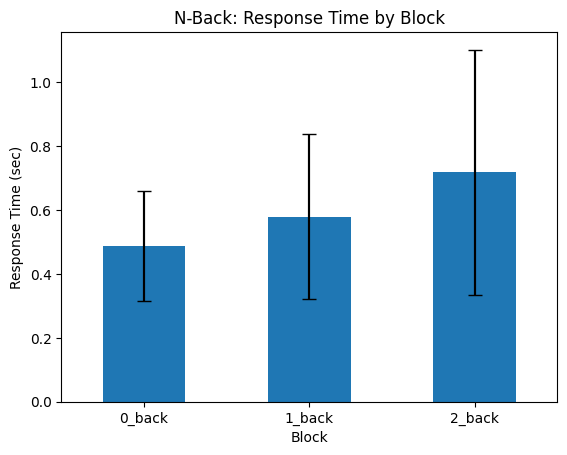

In [89]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataframe
df = behav_results

# Calculate the mean and standard deviation of response_time for each block
grouped_df = df.groupby(["block"])["response_time"].agg(["mean", "std"])

# Create the bar chart with error bars
ax = grouped_df.plot(kind="bar", y="mean", yerr="std", legend=False)

# Add error bars with caps
ax.errorbar(x=grouped_df.index, y=grouped_df["mean"], yerr=grouped_df["std"], fmt="none", capsize=5, ecolor="black")

# Rotate the xticklabels by 45 degrees
ax.set_xticklabels(grouped_df.index, rotation=0)

# Add axis labels and a title
ax.set_xlabel("Block")
ax.set_ylabel("Response Time (sec)")
ax.set_title("N-Back: Response Time by Block")

# Compute correct response proportions
avg_correct_response = df.groupby("block")["correct_response"].mean()
print(f"\nProportion correct by {avg_correct_response}")

# Display the chart
plt.show()


In [83]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.stats.multicomp as mc

# Load the dataframe
# df = df_no_nan

# Remove NaN rows
df_no_nan = df.dropna()
# df_no_nan = df.dropna(subset=["response_time"])

# Perform one-way ANOVA
f_value, p_value = stats.f_oneway(df[df["block"] == "0_back"]["response_time"],
                                df[df["block"] == "1_back"]["response_time"],
                                df[df["block"] == "2_back"]["response_time"])
print("ANOVA p-value:", p_value)
print("F-statistic:", f_value, "\n")

# Perform post hoc Tukey HSD test
m_comp = mc.MultiComparison(df["response_time"], df["block"])
result = m_comp.tukeyhsd()

# Print the pairwise comparisons and p-values
print(result)

# The table shows the pairwise comparisons between the blocks, the difference between 
# the means, the standard error, the lower and upper bounds of the confidence interval, 
# and the p-value for the comparison.

ANOVA p-value: 1.1101085160631986e-59
F-statistic: 143.18060731846208 

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj lower  upper  reject
-------------------------------------------------
0_back 1_back    0.091   0.0 0.0594 0.1227   True
0_back 2_back     0.23   0.0  0.198  0.262   True
1_back 2_back    0.139   0.0 0.1067 0.1713   True
-------------------------------------------------


P-values: [5.596602031039572e-18, nan, nan]


C:\Users\zackg\AppData\Local\Temp\ipykernel_15108\1666641484.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(grouped_df.index, rotation=0)


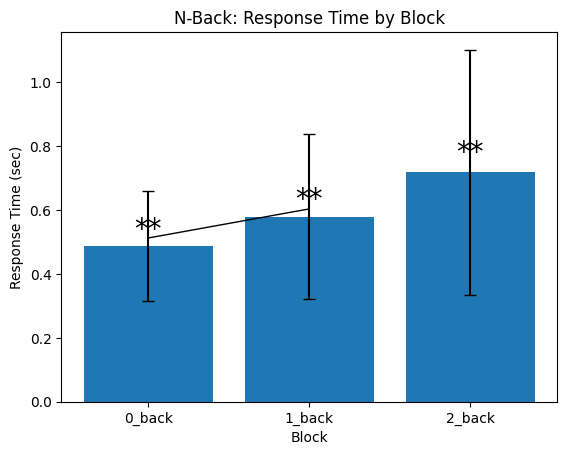

In [52]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

# Load the dataframe
df = df_no_nan

# Calculate the mean and standard deviation of response_time for each block
grouped_df = df.groupby(["block"])["response_time"].agg(["mean", "std"])

# Perform pairwise t-tests with Bonferroni correction
comparisons = [("1_back", "2_back"), ("2_back", "3_back"), ("1_back", "3_back")]
pvalues = []
for b1, b2 in comparisons:
    _, pvalue = stats.ttest_ind(df[df["block"] == b1]["response_time"], df[df["block"] == b2]["response_time"])
    pvalues.append(pvalue)
print(f"P-values: {pvalues}")
significance_markers = ["" if pvalue >= 0.05 else "*" if pvalue >= 0.01 else "**" for pvalue in pvalues]

# Create the bar chart with error bars and significance markers
fig, ax = plt.subplots()
ax.bar(grouped_df.index, grouped_df["mean"], yerr=grouped_df["std"], capsize=4)

# Rotate the xticklabels by 45 degrees
ax.set_xticklabels(grouped_df.index, rotation=0)

# Add significance markers and connecting lines to the bars
bar_centers = [rect.get_x() + rect.get_width() / 2 for rect in ax.patches]
bar_heights = [rect.get_height() for rect in ax.patches]
for i, (rect, sign) in enumerate(zip(ax.patches, significance_markers)):
    height = rect.get_height()
    x_center = bar_centers[i]
    y_offset = height * 0.05
    ax.text(x_center, height + y_offset, sign, ha="center", fontsize=20)
    if i < len(ax.patches) - 1:
        next_height = bar_heights[i+1]
        next_x_center = bar_centers[i+1]
        next_rect = ax.patches[i+1]
        if pvalues[i] < 0.05:
            ax.plot([x_center, next_x_center], [height + y_offset, next_height + y_offset], "k-", lw=1)

# Add axis labels and a title
ax.set_xlabel("Block")
ax.set_ylabel("Response Time (sec)")
ax.set_title("N-Back: Response Time by Block")

# Display the chart
plt.show()
